In [1]:
# importing libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sharad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# Reading the data
df = pd.read_csv("train.csv",nrows=100000) # taking 100k data points

print("Number of Rows and Column :" , df.shape)

Number of Rows and Column : (100000, 6)


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
id              100000 non-null int64
qid1            100000 non-null int64
qid2            100000 non-null int64
question1       100000 non-null object
question2       100000 non-null object
is_duplicate    100000 non-null int64
dtypes: int64(4), object(2)
memory usage: 4.6+ MB


* id: Looks like a simple rowID
* qid{1, 2}: The unique ID of each question in the pair
* question{1, 2}: The actual textual contents of the questions.
* is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.
* No null values

In [20]:
# checking the ratio of both the class labels (0 , 1)
from collections import Counter
Counter(df['is_duplicate'])


Counter({0: 62746, 1: 37254})

* The ratio (0.62746 : 0.37254) of class labels is not very imbalanced ,fairly balanced,no need for balancing the dataset.

### Number of unique questions

In [21]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

Total number of  Unique Questions are: 165931

Number of unique questions that appear more than one time: 19446 (11.719329118730075%)

Max number of times a single question is repeated: 32



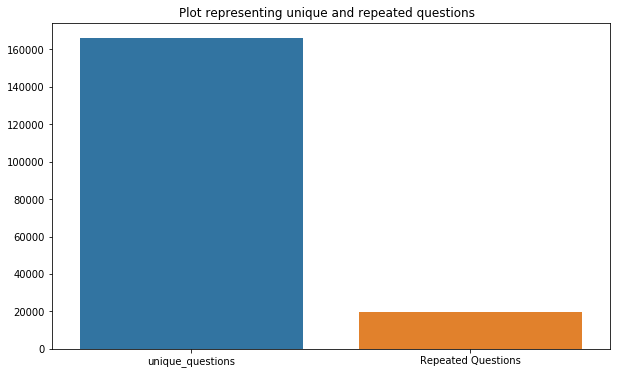

In [22]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]
plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [23]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate pair of questions:",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate pair of questions: 0


In [24]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


### Cleaning and Preprocessing the data

In [25]:
STOP_WORDS = stopwords.words("english")
def preprocess(x):
    '''Function to preprocess text data'''
    
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    #x = ' '.join(e for e in x.split() if e not in STOP_WORDS)
    porter = PorterStemmer()
    pattern = re.compile('\W')
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    return x

# preprocessing each question
df["question1"] = df["question1"].apply(preprocess)
df["question2"] = df["question2"].apply(preprocess)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0


# Basic Feature Extraction

In [26]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')  # Frequency of qid1's
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count') # Frequency of qid2's
df['q1len'] = df['question1'].str.len() # Length of q1
df['q2len'] = df['question2'].str.len() # Length of q2
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))  # Number of words in Question 1
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))  # Number of words in Question 2

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1) # (Number of common unique words in Question 1 and Question 2)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1) #(Total num of words in Question 1 + Total num of words in Question 2)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share_ratio'] = df.apply(normalized_word_share, axis=1) # (word_common)/(word_Total)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2'] # sum total of frequency of qid1 and qid2
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2']) # absolute difference of frequency of qid1 and qid2

df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share_ratio,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,15,13,12.0,25.0,0.480000,2,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,1,1,51,88,13,18,8.0,26.0,0.307692,2,0


#### Analysing some extracted features

In [27]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 11
Number of Questions with minimum length [question2] : 3


* There are questions (precisely 11 in question1 & 3 in question2) with only 1 word.

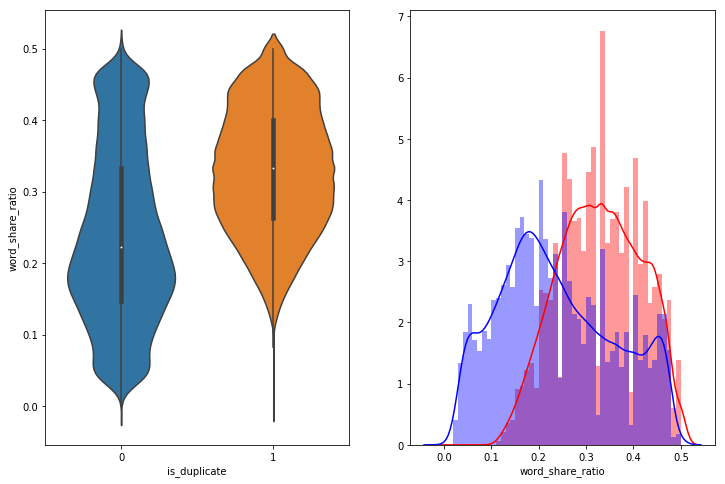

In [28]:
# Analysing word_share_ratio , i.e percentage of words shared by the question pairs
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share_ratio', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

* There is an overlapping of the class labels , but also as we can see , there are more of class label 1's(similar/Duplicates) when the word_share_ratio is more.

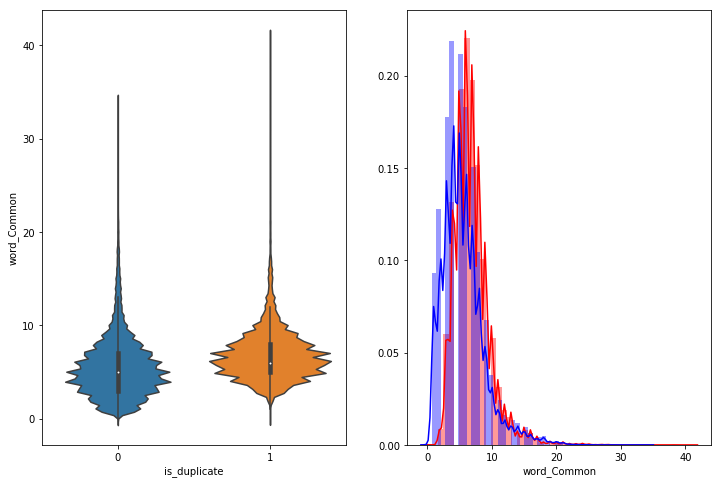

In [29]:
# Analysing word_Common , i.e Number of common unique words betwen the question pairs.

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

* The class labels are highly overlapping.

# Building more features

In [16]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 
STOP_WORDS = stopwords.words("english")
def preprocess(x):
    '''Function to preprocess text data'''
    
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    porter = PorterStemmer()
    pattern = re.compile('\W')
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    return x

def get_token_features(q1, q2):
    
    '''Function to get token features'''
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

df1 = pd.read_csv("train.csv",nrows=100000)
df_nlp = extract_features(df1)

df_nlp.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


#### Word Cloud of similar and dissimilar question pairs 

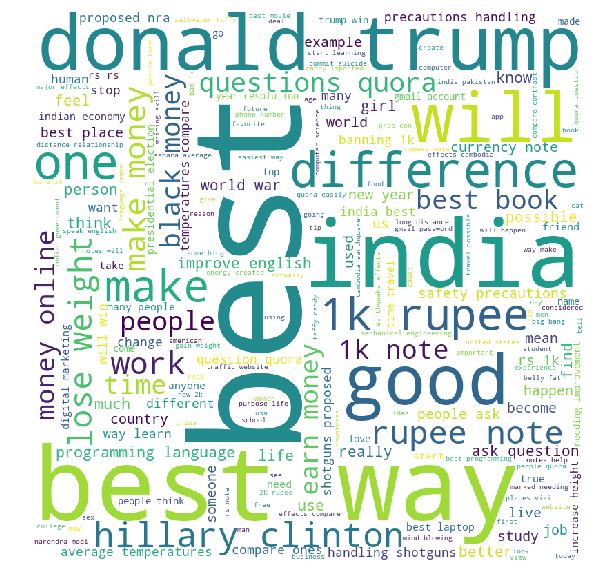

Word Cloud for Duplicate Question pairs


In [57]:
## Plot word cloud for similar and non similar question pairs
df_duplicate_Q12 = df_nlp.loc[(df_nlp['is_duplicate'] == 1),['question1','question2']]
df_duplicate_Q12['duplicate_words'] = df_duplicate_Q12['question1'] +  df_duplicate_Q12['question2']

from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS) 

for val in df_duplicate_Q12['duplicate_words']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

print("Word Cloud for Duplicate Question pairs")

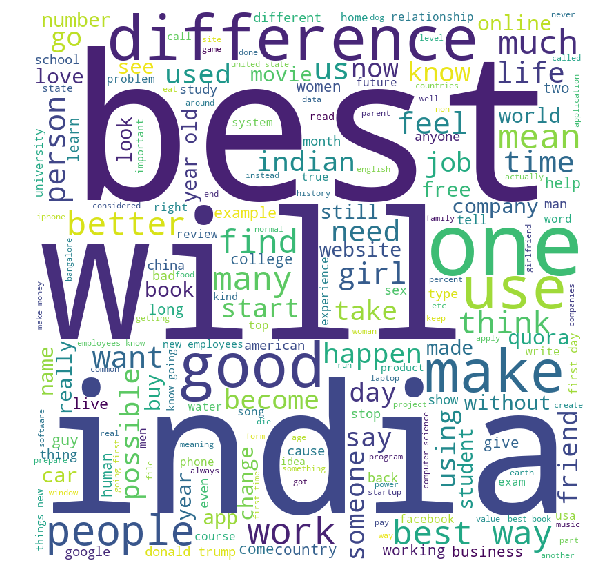

Word Cloud for Non - Duplicate Question pairs


In [58]:
df_nonduplicate_Q12 = df_nlp.loc[(df_nlp['is_duplicate'] == 0),['question1','question2']]

df_nonduplicate_Q12['duplicate_words'] = df_nonduplicate_Q12['question1'] +  df_nonduplicate_Q12['question2']

from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS) 

for val in df_nonduplicate_Q12['duplicate_words']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

print("Word Cloud for Non - Duplicate Question pairs")

##### Pair plots of  'ctc_max', 'cwc_max', 'csc_max', 'token_set_ratio'

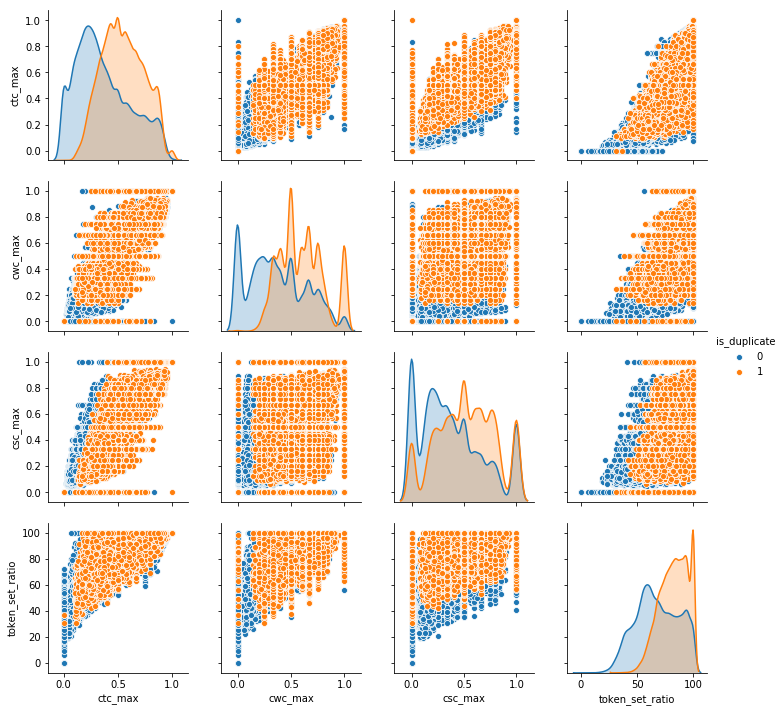

In [112]:
n = df_nlp.shape[0]
sns.pairplot(df_nlp[['ctc_max', 'cwc_max', 'csc_max', 'token_set_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_max', 'cwc_max', 'csc_max', 'token_set_ratio'])
plt.show()

* The features are fairly seperable

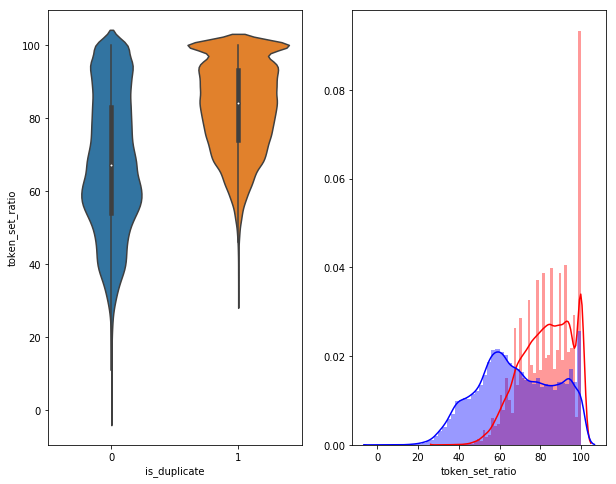

In [60]:
# Distribution of the token_set_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_set_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df_nlp[df_nlp['is_duplicate'] == 1.0]['token_set_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df_nlp[df_nlp['is_duplicate'] == 0.0]['token_set_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [61]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 2 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df_nlp[0:1000] # taking 1000 data points for memory issue 
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.031s...
[t-SNE] Computed neighbors for 1000 samples in 0.172s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.249303
[t-SNE] Computed conditional probabilities in 0.137s
[t-SNE] Iteration 50: error = 59.9196815, gradient norm = 0.2870782 (50 iterations in 0.795s)
[t-SNE] Iteration 100: error = 56.1636925, gradient norm = 0.2328880 (50 iterations in 0.569s)
[t-SNE] Iteration 150: error = 55.3895569, gradient norm = 0.2416712 (50 iterations in 0.556s)
[t-SNE] Iteration 200: error = 54.8512192, gradient norm = 0.2291942 (50 iterations in 0.478s)
[t-SNE] Iteration 250: error = 54.5953789, gradient norm = 0.2201367 (50 iterations in 0.477s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.595379
[t-SNE] Iteration 300: error = 0.6883183, gradient norm = 0.0008961 (50 iterations in 0.440s)
[t-SNE] Iteration 350: error = 0.5881208, gradient norm = 0.00035

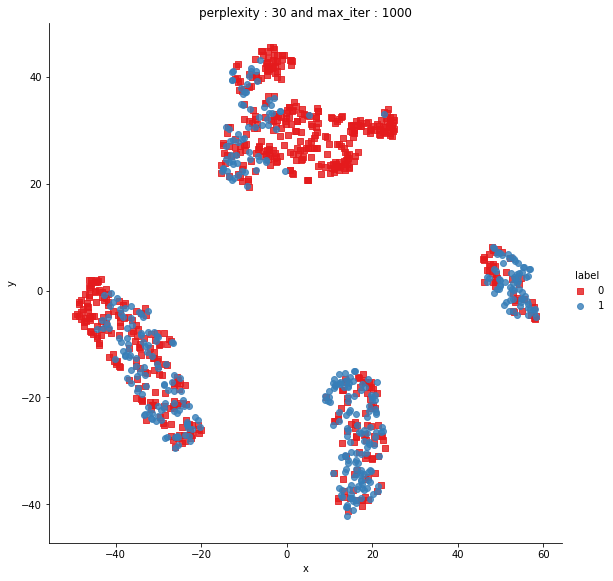

In [62]:
tsne2d = TSNE(n_components=2,init='random', random_state=101,method='barnes_hut',n_iter=1000,verbose=2
              ,angle=0.5).fit_transform(X)

df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

* There are regions where 0 class label are clearly seperated by 1 class label

# Preparing data for modelling

In [30]:
df = pd.read_csv("train.csv",nrows=100000) # taking 100k data points
STOP_WORDS = stopwords.words("english")
def preprocess(x):
    '''Function to preprocess text data'''
    
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    #x = ' '.join(e for e in x.split() if e not in STOP_WORDS)
    porter = PorterStemmer()
    pattern = re.compile('\W')
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    return x

# preprocessing each question
df["question1"] = df["question1"].apply(preprocess)
df["question2"] = df["question2"].apply(preprocess)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0


### Test train split

In [32]:
# remove the first row 
y_true = df['is_duplicate']
df.drop(['id','is_duplicate'], axis=1, inplace=True)

In [34]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

In [35]:
## Creating features for test and train seperately
## basic features
X_train['freq_qid1'] = X_train.groupby('qid1')['qid1'].transform('count')  # Frequency of qid1's
X_train['freq_qid2'] = X_train.groupby('qid2')['qid2'].transform('count') # Frequency of qid2's
X_train['q1len'] = X_train['question1'].str.len() # Length of q1
X_train['q2len'] = X_train['question2'].str.len() # Length of q2
X_train['q1_n_words'] = X_train['question1'].apply(lambda row: len(row.split(" ")))  # Number of words in Question 1
X_train['q2_n_words'] = X_train['question2'].apply(lambda row: len(row.split(" ")))  # Number of words in Question 2
X_train['word_Common'] = X_train.apply(normalized_word_Common, axis=1) # (Number of common unique words in Question 1 and Question 2)
X_train['word_Total'] = X_train.apply(normalized_word_Total, axis=1) #(Total num of words in Question 1 + Total num of words in Question 2)
X_train['word_share_ratio'] = X_train.apply(normalized_word_share, axis=1) # (word_common)/(word_Total)
X_train['freq_q1+q2'] = X_train['freq_qid1']+X_train['freq_qid2'] # sum total of frequency of qid1 and qid2
X_train['freq_q1-q2'] = abs(X_train['freq_qid1']-X_train['freq_qid2']) # absolute difference of frequency of qid1 and qid2

############## test
X_test['freq_qid1'] = X_test.groupby('qid1')['qid1'].transform('count')  # Frequency of qid1's
X_test['freq_qid2'] = X_test.groupby('qid2')['qid2'].transform('count') # Frequency of qid2's
X_test['q1len'] = X_test['question1'].str.len() # Length of q1
X_test['q2len'] = X_test['question2'].str.len() # Length of q2
X_test['q1_n_words'] = X_test['question1'].apply(lambda row: len(row.split(" ")))  # Number of words in Question 1
X_test['q2_n_words'] = X_test['question2'].apply(lambda row: len(row.split(" ")))  # Number of words in Question 2
X_test['word_Common'] = X_test.apply(normalized_word_Common, axis=1) # (Number of common unique words in Question 1 and Question 2)
X_test['word_Total'] = X_test.apply(normalized_word_Total, axis=1) #(Total num of words in Question 1 + Total num of words in Question 2)
X_test['word_share_ratio'] = X_test.apply(normalized_word_share, axis=1) # (word_common)/(word_Total)
X_test['freq_q1+q2'] = X_test['freq_qid1']+X_test['freq_qid2'] # sum total of frequency of qid1 and qid2
X_test['freq_q1-q2'] = abs(X_test['freq_qid1']-X_test['freq_qid2']) # absolute difference of frequency of qid1 and qid2

print(X_train.shape)
print(X_test.shape)

(70000, 15)
(30000, 15)


In [37]:
## Advance features
# Train
X_train = extract_features(X_train)

# Test 
X_test = extract_features(X_test)

print(X_train.shape)
print(X_test.shape)

(70000, 30)
(30000, 30)


In [51]:
## tfidf features
from sklearn.feature_extraction.text import TfidfVectorizer
# merge texts
# test train question1 and 2
print("test train question1 tfidf")
vectorizer_tfidf_q1 = TfidfVectorizer(min_df=20,ngram_range=(1,2), max_features=1000) # limiting max_features to 1000 ,due to memory issues
vectorizer_tfidf_q1.fit(X_train['question1'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_q1_tfidf = pd.DataFrame(vectorizer_tfidf_q1.transform(X_train['question1'].values).todense())
X_test_q1_tfidf = pd.DataFrame(vectorizer_tfidf_q1.transform(X_test['question1'].values).todense())

print(X_train_q1_tfidf.shape)
print(X_test_q1_tfidf.shape)

print("test train question2 tfidf")
vectorizer_tfidf_q2 = TfidfVectorizer(min_df=20,ngram_range=(1,2), max_features=1000) 
vectorizer_tfidf_q2.fit(X_train['question2'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_q2_tfidf = pd.DataFrame(vectorizer_tfidf_q2.transform(X_train['question2'].values).todense())
X_test_q2_tfidf = pd.DataFrame(vectorizer_tfidf_q2.transform(X_test['question2'].values).todense())

print(X_train_q2_tfidf.shape)
print(X_test_q2_tfidf.shape)



test train question1 tfidf
(70000, 1000)
(30000, 1000)
test train question2 tfidf
(70000, 1000)
(30000, 1000)


In [113]:
## Concatinating all the features
final_features_train = pd.concat([X_train.reset_index(drop=True),X_train_q1_tfidf.reset_index(drop=True),
                                  X_train_q2_tfidf.reset_index(drop=True)],axis = 1)

final_features_test = pd.concat([X_test.reset_index(drop=True),X_test_q1_tfidf.reset_index(drop=True),
                                  X_test_q2_tfidf.reset_index(drop=True)],axis = 1)

final_features_train.drop(['qid1', 'qid2', 'question1', 'question2'], axis=1, inplace=True)
final_features_test.drop(['qid1', 'qid2', 'question1', 'question2'], axis=1, inplace=True)

print(final_features_train.shape)
print(final_features_test.shape)

(70000, 2026)
(30000, 2026)


# Modelling

In [ ]:
# we convert all the features into numeric before we apply any model
# train
cols = list(final_features_train.columns)
for i in cols:
    final_features_train[i] = final_features_train[i].apply(pd.to_numeric)
# test
cols = list(final_features_test.columns)
for i in cols:
    final_features_test[i] = final_features_test[i].apply(pd.to_numeric)

y_train = list(map(int, y_train.values))
y_test = list(map(int, y_test.values))

In [57]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Random model for getting worst case log-loss

Log loss on Test Data using Random Model 0.8884901904955773


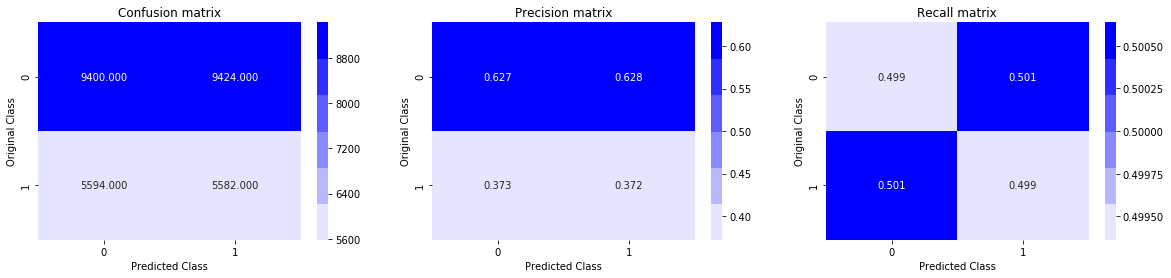

In [58]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
predicted_y = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.5366220941267933
For values of alpha =  0.0001 The log loss is: 0.5324315267358325
For values of alpha =  0.001 The log loss is: 0.5372296587462063
For values of alpha =  0.01 The log loss is: 0.530616082794197
For values of alpha =  0.1 The log loss is: 0.5406335738194862
For values of alpha =  1 The log loss is: 0.5697410784155483
For values of alpha =  10 The log loss is: 0.5948614704185613


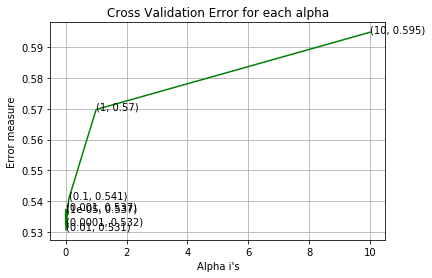

For values of best alpha =  0.01 The train log loss is: 0.501330691720133
For values of best alpha =  0.01 The test log loss is: 0.530616082794197
Total number of data points : 30000


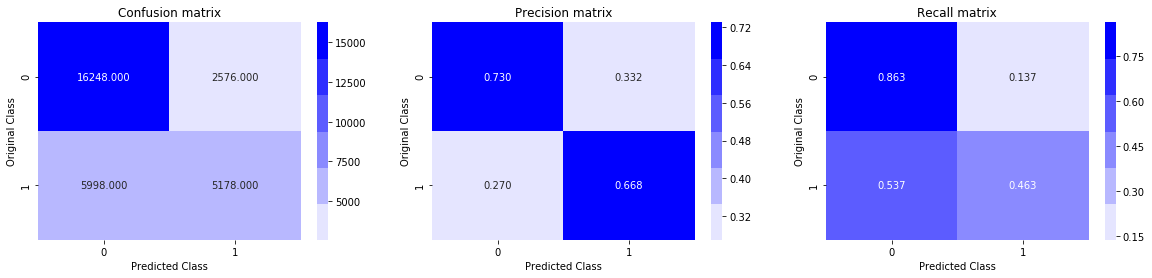

In [62]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier(loss == log).
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(final_features_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(final_features_train, y_train)
    predict_y = sig_clf.predict_proba(final_features_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(final_features_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(final_features_train, y_train)

predict_y = sig_clf.predict_proba(final_features_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(final_features_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Linear SVM

For values of alpha =  1e-05 The log loss is: 0.5486489616141316
For values of alpha =  0.0001 The log loss is: 0.5387531135860343
For values of alpha =  0.001 The log loss is: 0.5248869694266476
For values of alpha =  0.01 The log loss is: 0.5434633041436795
For values of alpha =  0.1 The log loss is: 0.5403151278954912
For values of alpha =  1 The log loss is: 0.5622924966628433
For values of alpha =  10 The log loss is: 0.587987112969123


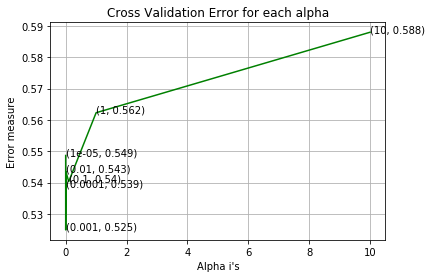

For values of best alpha =  0.001 The train log loss is: 0.49680380286073517
For values of best alpha =  0.001 The test log loss is: 0.5248869694266476
Total number of data points : 30000


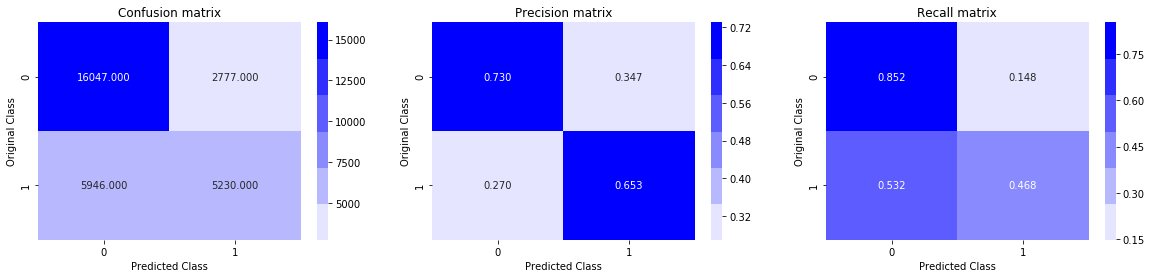

In [63]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(final_features_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(final_features_train, y_train)
    predict_y = sig_clf.predict_proba(final_features_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(final_features_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(final_features_train, y_train)

predict_y = sig_clf.predict_proba(final_features_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(final_features_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### XGBOOST

In [98]:
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import xgboost as xgb



final_features_train1 = final_features_train.to_numpy()
final_features_train1 = final_features_train1.astype(np.float32)
y_train1 = np.array(y_train)
y_train1 = y_train1.astype(np.float32)

XGB = xgb.XGBClassifier(objective='binary:logistic',n_jobs = 0) 

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 5)]
max_depth = [int(x) for x in np.linspace(2, 11, num = 4)]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth
               }

clf = RandomizedSearchCV(XGB, random_grid , cv=3,scoring = 'neg_log_loss')
clf.fit(final_features_train1, y_train1)



RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=0, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [10, 257, 505, 752, 1000], 'max_depth': [2, 5, 8, 11]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_log_loss', verbose=0)

Train log loss scores


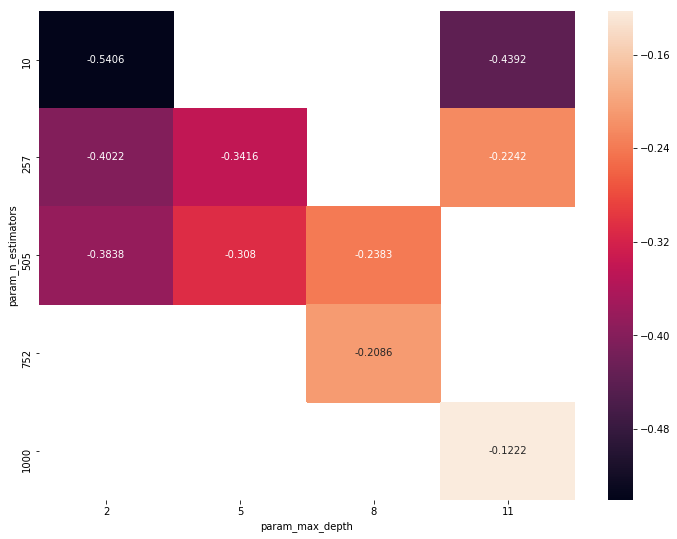

In [102]:
XGB_randomsearch = pd.DataFrame(clf.cv_results_)


print('Train log loss scores')
min_scores = XGB_randomsearch.groupby(['param_n_estimators', 
                                    'param_max_depth']).min()
min_scores = min_scores.unstack()[['mean_train_score']]
plt.figure(figsize=(12, 9))
sns.heatmap(min_scores.mean_train_score, annot=True, fmt='.4g');

Test log loss scores


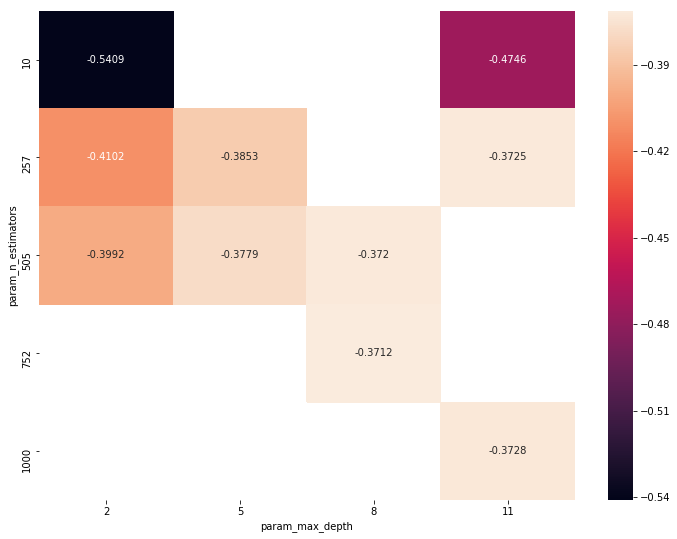

In [148]:
## https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
print("Test log loss scores")
min_scores = XGB_randomsearch.groupby(['param_n_estimators', 
                                    'param_max_depth']).min()
min_scores = min_scores.unstack()[['mean_test_score']]
plt.figure(figsize=(12, 9))
sns.heatmap(min_scores.mean_test_score, annot=True, fmt='.4g');

* Taking Max depth = 2 and n_estimators = 505

In [124]:
import xgboost as xgb
## Code Source : https://stackoverflow.com/questions/24685012/pandas-dataframe-renaming-multiple-identically-named-columns
def df_column_uniquify(df):
    '''This funtion renames any duplicate column , 
    EX : columns:[A , B , A , A] will be [A , B , A_1 , A_2]'''
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

final_features_train = df_column_uniquify(final_features_train)
final_features_test = df_column_uniquify(final_features_test)

d_train = xgb.DMatrix(final_features_train, label=y_train)
d_test = xgb.DMatrix(final_features_test, label=y_test)


In [157]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.1
params['max_depth'] = 2

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 505, watchlist, early_stopping_rounds=20, verbose_eval=100)

[0]	train-logloss:0.664742	valid-logloss:0.667325
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[100]	train-logloss:0.425574	valid-logloss:0.45371
[200]	train-logloss:0.409648	valid-logloss:0.440284
[300]	train-logloss:0.400332	valid-logloss:0.432821
[400]	train-logloss:0.392615	valid-logloss:0.427148
[500]	train-logloss:0.386723	valid-logloss:0.42306
[504]	train-logloss:0.386547	valid-logloss:0.422912


In [158]:
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

The test log loss is: 0.42291274187100597


Total number of data points : 30000


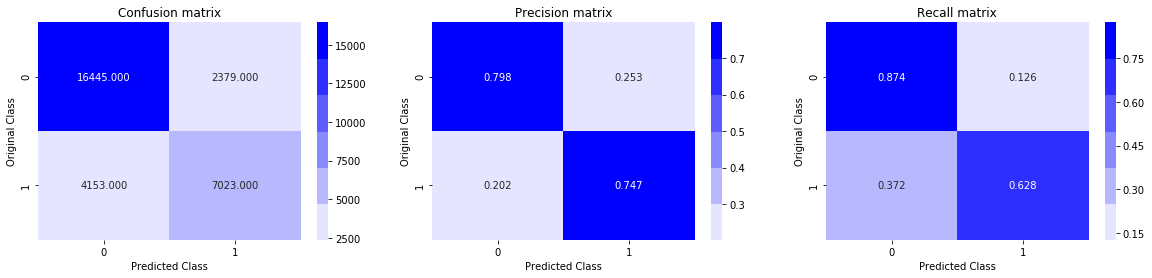

In [159]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Procedure Followed :

* Reading the data 
* Checking for null values
* checking for class imbalance
* Preprocessing the data
* Feature Extractions and Analysis
* Word Cloud for similar and dissimilar question pairs
* Visualising using T-SNE
* Preparing data for modelling 
    * test - train split
    * building features for test and train seperately to avoid data leakage
    * building tfidf for test train
    * Concatenating all the features (Extracted and tfidf) , for test and train , thus making final test and train set
* Modelling
    * Logistic Regression
    * Linear SVM
    * XGBOOST


## CONCLUSION : 

In [160]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Algorithm" , 'train log_loss' , 'test log_loss']

x.add_row(["Logistic Regression", 0.50, 0.53])
x.add_row(["Linear SVM", 0.49, 0.52])
x.add_row(["XGBOOST", 0.38, 0.42])

print(x)


+---------------------+----------------+---------------+
|      Algorithm      | train log_loss | test log_loss |
+---------------------+----------------+---------------+
| Logistic Regression |      0.5       |      0.53     |
|      Linear SVM     |      0.49      |      0.52     |
|       XGBOOST       |      0.38      |      0.42     |
+---------------------+----------------+---------------+


# References
* https://stackoverflow.com/questions/24685012/pandas-dataframe-renaming-multiple-identically-named-columns